# Исследование продаж компьютерных игр

Передо мной данные интернет-магазина, который осуществляет продажу компьютерных игр по всему миру.  
В датасете есть информация о продажах игр, оценки пользователей и экспертов, жанр и платформы, на которых игра представлена, а также их возрастной рейтинг, оцененный ESRB (Entertainment Software Rating Board).  

**Цель исследования:** выявить закономерности, определяющие коммерческую успешность игры.

**Ход исследования:**  
1. Предобработка данных  
    - Заполнение пропусков  
    - Приведение данных к нужным форматам  
    - Добавление столбца  
2. Исследовательский анализ
    - Развитие рынка компьютерных игр и платформ
    - Определение актуального периода для прогнозирования
    - Исследование платформ в актуальном периоде
    - Изучение влияния отзывов на продажи
    - Распределение по жанрам
3. Анализ регионов
    - Анализ продаж в регионе по жанру, платформе и рейтингу
    - Составление портрета потребителя
4. Проверка гипотез
    - О различиях в пользовательских рейтингах для платформ Xbox One и PC  
    - О различиях в пользовательских рейтингах для жанров Action и Sports

## Знакомство с данными

Для начала импортирую библиотеки, которые мне понадобятся для выполнения исследования

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

Прочитаю данные, сохраню их в переменную `data` и выведу информацию о ней.

In [2]:
data = pd.read_csv(r'C:\Users\HOME\Desktop\Practicum\datasets\games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Переименую столбцы так, чтобы они соответствовали "змеиному регистру":

In [4]:
data.columns = data.columns.str.lower()

Посмотрю, как выглядят данные прежде чем приступить к предобработке

In [5]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Набор данных включает в себя название продаваемой игры, ее платформу, год релиза, жанр, а также продажи, разделенные на четыре региона: Северная Америка (na - North America), Европа (eu - Europe), Япония (jp - Japan) и другие (other).  
Также есть три рейтинга игры - рейтинг игроков и критиков (оценка игры) и возрастной рейтинг, который определяет ESRB.  
Уже в первых строках кода видно, что в столбцах есть пропуски и некоторые из столбцов представлены в неподобающем для них формате (например, год релиза - число с плавающей запятой).  
Насколько это возможно, исправлю данные на следующем этапе предобработки.

## Предобработка

В первую очередь проверю данные на наличие явных дубликатов

In [6]:
data.duplicated(subset=['name', 'platform','year_of_release', 'genre']).sum()

2

По ключевым столбцам обнаружено два дубликата. Удалю их:

In [7]:
data = data.drop_duplicates(subset=['name', 'platform','year_of_release', 'genre'])

Изучу пропущенные значения

In [8]:
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

### Заполнение пропусков в году выпуска

Посмотрю, как выглядят строки, в которых пропущен год выпуска.

In [9]:
data[data.year_of_release.isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Видно, что у некоторых игр год стоит в конце названия. Перенесу его в столбец с годом выпуска:

In [10]:
#Переберу индексы тех, у кого пустое значение года выпуска
for i in data[data.year_of_release.isna()].index:
    #Если в названии есть число, начинающееся с 20, find вернет значение больше 0
    if data.loc[i, 'name'].find('20') > 0:
        #Так как год стостоит из 4 символов и стоит в конце строки, то
        #разнциа между длиной строки и найденной "20" должна быть равна 4
        if len(data.loc[i, 'name']) - data.loc[i, 'name'].find('20') == 4: 
            #для таких строк перенесу эти значения в столбец года
            data.loc[i, 'year_of_release'] = \
            int(data.loc[i, 'name'][data.loc[i, 'name'].find('20') : len(data.loc[i, 'name'])])
            #из столбца имени вытащу интересующие символы и сразу преобразую их в int

Теперь строки с ранее пустыми значениями года выпуска выглядят так:

In [11]:
data.loc[[183, 377, 475, 1650, 3486]]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2004.0,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,2004.0,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,2006.0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
1650,NASCAR Thunder 2003,PS2,2003.0,Racing,0.60,0.46,0.00,0.16,84.0,8.7,E
3486,Madden NFL 2002,XB,2002.0,Sports,0.53,0.02,0.00,0.03,90.0,8.1,E


### Что с другими пропусками?

In [12]:
pd.DataFrame(round(data.isna().mean()*100, 1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.500000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Немного пропусков еще осталось в году релиза, но их заполнить без ошибки уже не получится.  
Наибольшая доля пропусков - в колонках, связанных с рейтингом.

К сожалению, заполнить их так, чтобы это не было ошибкой - трудно. Но и стоит ли их заполнять?  
- Пропуски в `critic_score` могут быть обусловлены тем, что какую-то игру критики попросту не оценивали.  
- С `user_score` может быть такая же ситуация. Какая-то часть игр может относиться к году выпуска, в который еще не было площадок, на которых игроки могли бы оценить игру. Теоретически здесь можно восстановить пропущенные значения, опираясь на медианные значения по жанру игры или платформе, но так как пропусков достаточно много - вставленные медианные значения могут существенно исказить результаты исследовательского анализа.
- `rating` может быть пропущен, так как ESRB не давало возрастной оценки для игры.

Принимая во внимание вышеуказанное, решено не заполнять оставшиеся пропуски в оценках критиков и игроков, чтобы избежать искажения результатов анализа.

#### Заполнение пропусков в рейтинге ESRB

Изучу уникальные значения колонки рейтинга.

In [13]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Рейтинг E (everyone) изначально назывался K-A (kids to adults). Поэтому объединю их в одну группу E.

In [14]:
data.loc[data['rating'] == 'K-A', 'rating'] = 'E'

Чтобы данные по присвоенному рейтингу в полном объеме учитывались при дальнейшем составлении портрета потребителя, заменю пропуски.  
Для некоторых игр уже есть рейтинг RP (rating pending), т.е. рейтинг ожидается.  
Думаю, будет ошибкой заменить пропуски на RP - нельзя утверждать, что для игр, у которых нет рейтинга - он в скором времени появится, так как ESRB оценивает не все игры поголовно.  
Поэтому заменю пропуски на ND (not defined) - не определен.

In [15]:
data.loc[data['rating'].isna(), 'rating'] = 'ND'

### Поиск неявных дубликатов

Посмотрю столбец `platform`

In [16]:
data.platform.sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Неявных дубликатов не наблюдается.  
Что насчет столбца `genre`?

In [17]:
data.genre.sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

Здесь же разберусь, почему у колонки `user_score` тип данных _object_? Посмотрю его уникальные значаения.

In [18]:
data.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [19]:
print('Кол-во строк оценки с "tbd":', \
      data.loc[data['user_score'] == 'tbd', 'user_score'].count())

Кол-во строк оценки с "tbd": 2424


Все из-за значений с аббревиатурой tbd, которая означает "to be determined", то есть "предстоит определить".  
Возможно, такое значение ставится играм, которые не оценило достаточно пользователей, чтобы можно было определить среднюю оценку.  
Так или иначе, уберу tbd и оставлю вместо этого пропуски.

In [20]:
data['user_score'].replace({'tbd' : np.nan}, inplace=True)

### Приведение данных к надлежащим форматам

In [21]:
#user_score к float
data['user_score'] = pd.to_numeric(data['user_score'])

#Так как дан только год, преобразую данные в int вместо datetime
data['year_of_release'] = data['year_of_release'].astype('Int64')

### Добавление столбца всех продаж

В `total_sales` запишу данные по всем продажам игры:

In [22]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Этот столбец понадобится для дальнейшего исследовательского анализа.

Посмотрю на строки с пустым жанром и названием.

In [23]:
data.query('genre.isna() or name.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,ND,2.39


Оставлю в датафрейме только те строки, у которых есть данные о жанре.

In [24]:
data = data[data['genre'].notna()]

## Исследовательский анализ

### Динамика публикации игр по годам

Посмотрю количество игр, которое выпускалось в зависимости от года.

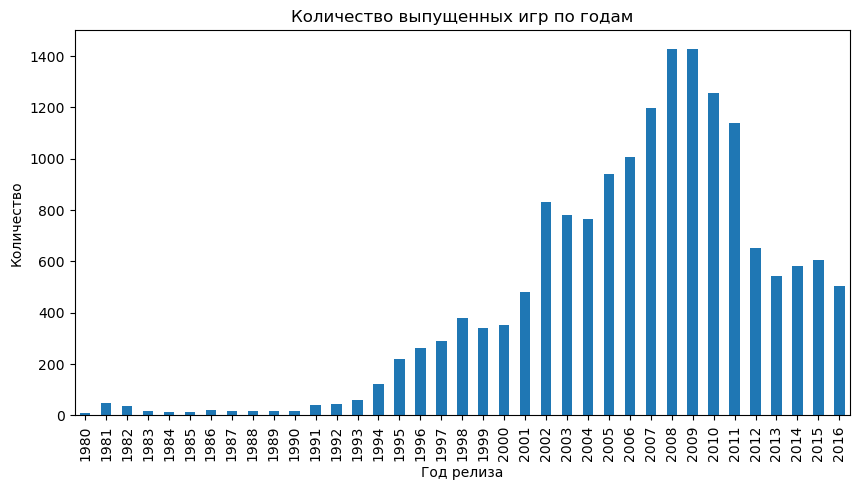

In [25]:
(data.groupby('year_of_release').agg({'name':'count'})
     .plot(kind='bar', legend=False, title='Количество выпущенных игр по годам',\
          figsize=(10,5)))
plt.xlabel('Год релиза')
plt.ylabel('Количество');

До 1994 года выпускалось сравнительно мало игр - до 50 штук в год.  
Сильный рост заметен с 2002 года, когда технологии развились достаочно, чтобы выпускать 830 игр в год.  
2008 год - лидер по количеству выпущенных игр, тогда их вышло 1429 штук.

### Продажи по платформам

Посмотрю, как изменялись продажи по годам в зависимости для разных игровых платформ.

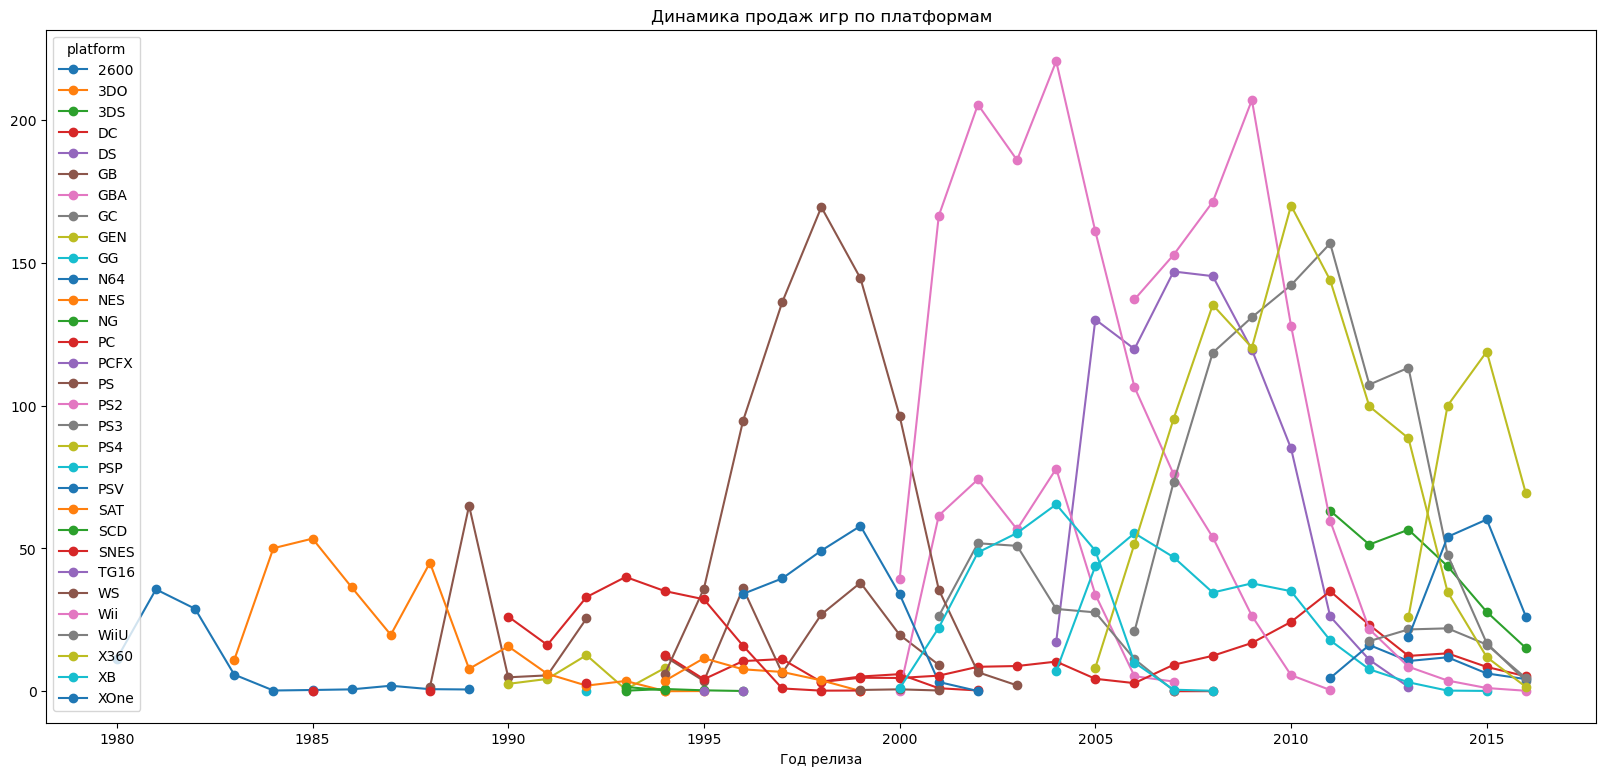

In [26]:
#В переменную сохраню данные по продажам для каждой платформы
sales_by_platform = data.pivot_table(columns='platform', index='year_of_release', \
                                     values='total_sales', aggfunc='sum')

#Построю график динамики продаж для платформ
sales_by_platform.plot(style='o-', figsize=(20,9), title='Динамика продаж игр по платформам')
plt.xlabel('Год релиза');

Конечно, в таком обилии платформ трудно разобраться детально, но главное, что видно - это тот факт, что платформы переживают довольно короткий жизненный цикл от роста до старости. Например, самая высокая розовая линия - продажи по PlayStation 2. С 2000 по 2005 эта консоль актуальна и на нее выпускают много игр, но потом количество продаж резко убывает и прекращается вовсе в 2011 году. Тенденция объяснима тем, что технологии совершенствуются, и старые платформы не выдерживают новых, более требовательных игр. А также тем фактом, что владельцы платформ могут совершать покупки тогда, когда приобрели консоль и после докупать существенно меньше игр или не покупать их вовсе.

Для пяти крупнейших платформ по суммарным продажам построю отдельный график.

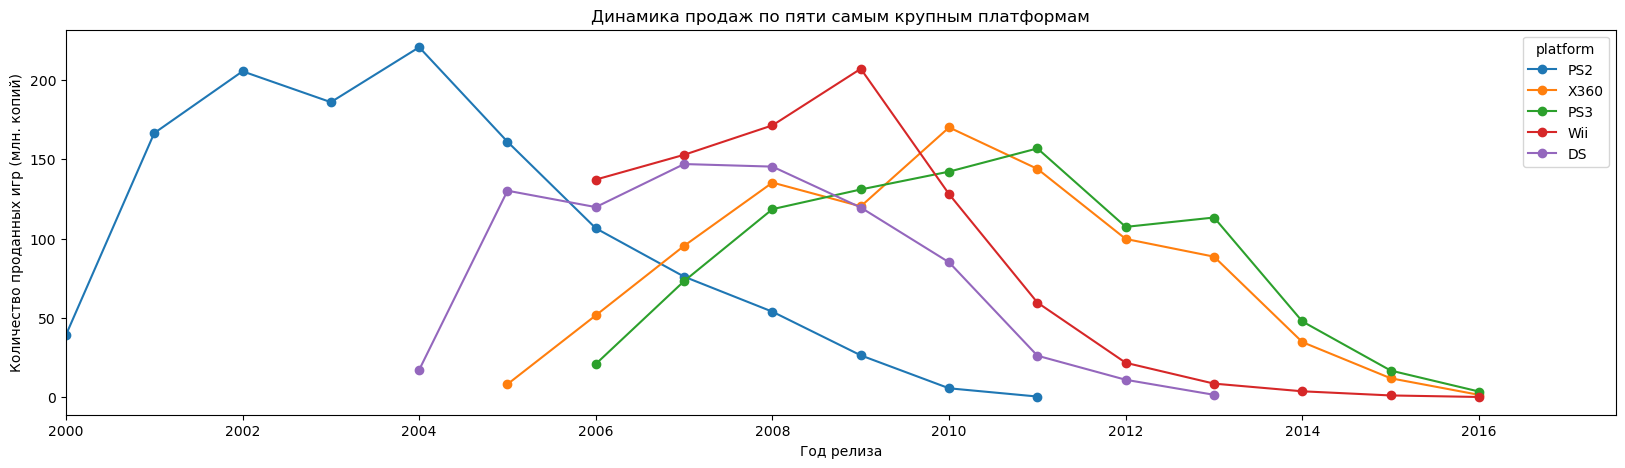

In [27]:
(sales_by_platform[
    sales_by_platform.sum(axis=False).sort_values(ascending=False)
    .head(5).index.tolist()]
.plot(style='o-', figsize=(20,5), title='Динамика продаж по пяти самым крупным платформам'))
plt.xlabel('Год релиза')
plt.ylabel('Количество проданных игр (млн. копий)')
plt.xlim(2000);

Посмотрю также, сколько обычно платформы держатся на рынке.

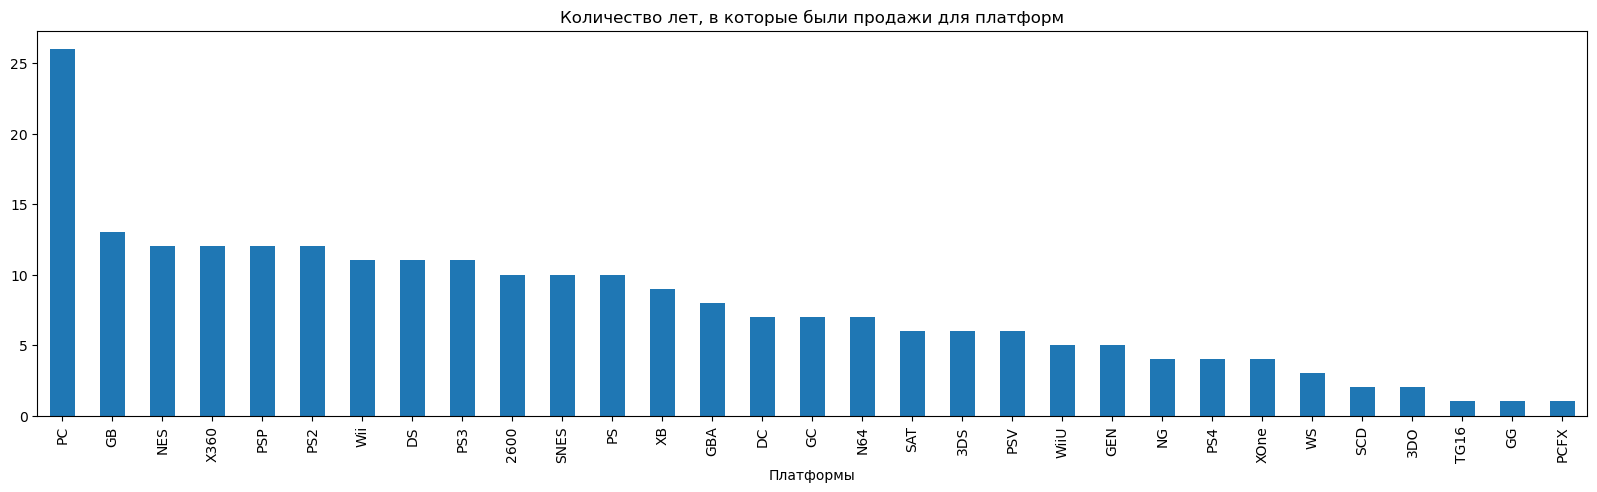

In [28]:
((~sales_by_platform.isna()).sum()
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(20,5),\
    title='Количество лет, в которые были продажи для платформ'))
plt.xlabel('Платформы');

In [29]:
print('Медианная продолжительность жизни платоформы -',
#оставлю только те платформы, у которых к 2016 нет продаж, то есть цикл окончен
(sales_by_platform.T[sales_by_platform.T[2016].isna()]
 #посмотрю количество лет, в которые были продажи + уберу однолетки
 .notna().sum(axis=1).loc[lambda x: x >1]
 #и найду медиану
 .median()))

Медианная продолжительность жизни платоформы - 8.0


Обычно платформы поддерживаются около 8 лет. Но возможен и более долгий период.  
Например, лидер продаж - PlayStation 2 - просуществовала на рынке 11 лет, однако ее последние 7 лет присутствия продажи только убывали.  
Важно также обратить внимание на то, что ПК - держится лучше всех платформ, 26 лет.  
Заметно также, что продажи у _всех_, в свое время ведущих, платформ - неизменно убывают после около 4 лет роста.  
Это важно понимать, чтобы прогнозировать продажи в дальнейшем.

### Определение актуального периода для прогнозирования

Так как платформы на рынке компютерных игр постоянно обновляются, важно учесть наиболее актуальные. Поэтому возьму период с 2013 года - года, когда вышло новое поколение приставок PS4 и Xbox One. Тогда в распоряжении будут данные за 3 полных года и один неполный 2016.

In [30]:
data_rel = data.dropna(subset='year_of_release')
data_rel['year_of_release'] = data_rel['year_of_release'].astype('int')
data_rel = data_rel.query('year_of_release >= 2013')

C:\Users\HOME\AppData\Local\Temp\ipykernel_18528\2215062164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rel['year_of_release'] = data_rel['year_of_release'].astype('int')


### Платформы в актуальном периоде

#### Анализ динамики продаж по платформам

Снова посмотрю продажи по платформам, но на этот раз с актуального периода.  
Датафрейм назову `platforms_rel`, то есть _relevant (актуальные)_

In [31]:
platforms_rel = data_rel.pivot_table(index='year_of_release', columns='platform', \
                                 values='total_sales', aggfunc='sum')

platforms_rel

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


У платформ DS и PSP - нет продаж к 2016 году. Значит, эти платформы более не актуальны, удалю их их этой переменной и основной.

In [32]:
data_rel = data_rel.query('platform not in ["DS", "PSP"]')
platforms_rel = platforms_rel.dropna(axis=1)

Количество платформ уже заметно сократилось, изучать их легче.  
Для платформ посчитаю процентные изменения из года в год.

In [33]:
#Для этого переберу платформы
for i in platforms_rel.columns:
    #и добавлю для них столбец с '_ch' (change, изменения)
    platforms_rel[i + '_ch'] = platforms_rel[i].pct_change()
    #Чтобы цикл не продолжался бесконечно, оборву его на моменте,
    #когда он добирается до первой колонки с процентным изменением
    if i in '_ch':
        break

C:\Users\HOME\AppData\Local\Temp\ipykernel_18528\2279146943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  platforms_rel[i + '_ch'] = platforms_rel[i].pct_change()


Посмотрю на динамику продаж платформ на актуальный период.

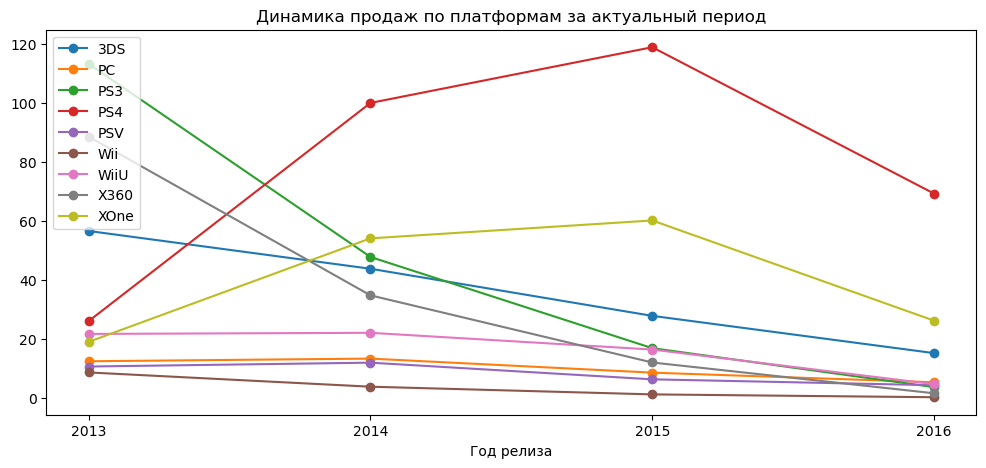

In [34]:
platforms_rel.loc[:, :'XOne'].plot(style='o-',
                                   figsize=(12,5),
                                   title='Динамика продаж по платформам за актуальный период')
plt.legend(loc='upper left')
plt.xticks(np.arange(2013, 2017, step=1))
plt.ylabel('')
plt.xlabel('Год релиза');

И оценю их, опираясь на средние изменения и изменения в последний год.

In [46]:
(pd.DataFrame(data=platforms_rel.T.loc['3DS_ch':, 2015])
 .join(
     pd.DataFrame(platforms_rel.T.loc['3DS_ch':].mean(axis=True), columns=['ср. изм.'])
 )
 .sort_values(by='ср. изм.', ascending=False)
 .style.background_gradient('coolwarm')).format('{:.3f}')

,2015,ср. изм.
platform,,
PS4_ch,0.189,0.873
XOne_ch,0.112,0.466
PC_ch,-0.358,-0.223
PSV_ch,-0.475,-0.224
WiiU_ch,-0.258,-0.320
3DS_ch,-0.365,-0.349
PS3_ch,-0.648,-0.671
Wii_ch,-0.696,-0.701
X360_ch,-0.656,-0.712


Таблица отражает средние изменения и изменения за последний год. Соответственно, чем ярче обе ячейки - тем лучше (тем выше рост продаж)  
В 2016 году по графику видно, что продажи по всем платформам сократились. И за рассматриваемый период с 2013 года не появлялось новых платформ.  
Тем не менее привлекательные платформы еще остаются, это:  
**Более надежные**
- PS4. Показывает лучшие темпы роста за период и на конец 2016 является платформой с наибольшими продажами.
- Xbox One. Вторая крупнейшая платформа по продажам в 2016 году с хорошими средними темпами роста (в 2 раза меньше PS4)
- PC. Это самая стабильная платформа, продажи игр для которой держатся дольше всех. В 2016 году она заняла 4 место по продажам.


**Менее надежные / Краткосрочно надежные**
- Nintendo 3DS. Продажи по платформе снижаются, относительно других она старая (хоть несмотря на это является топ-3 платформой по продажам за 2016). В последующие год-два еще можно рассчитывать на приемлемые продажи. Эта платформа стабильно снижается где-то на 30% каждый год.
- PS Vita. Хотя абсолютные продажи у этой платформы низкие, тем не менее они достаточно стабильно приносят доход.

Но стоит учесть, что к "более надежным" относятся основные игроки рынка - PlayStation и XBox с приставками, которым 4 года. Они будут приносить выручку еще около двух лет, но затем ожидаемо произойдет обновление, и будут выпущены новые поколения приставок, для которых потребуются уже другие игры.

#### Анализ продаж по ключевым платформам

Построю "ящик с усами" для продаж по игровым платформам, выделю цветом платформы, которые посчитал потеницально перспективными.

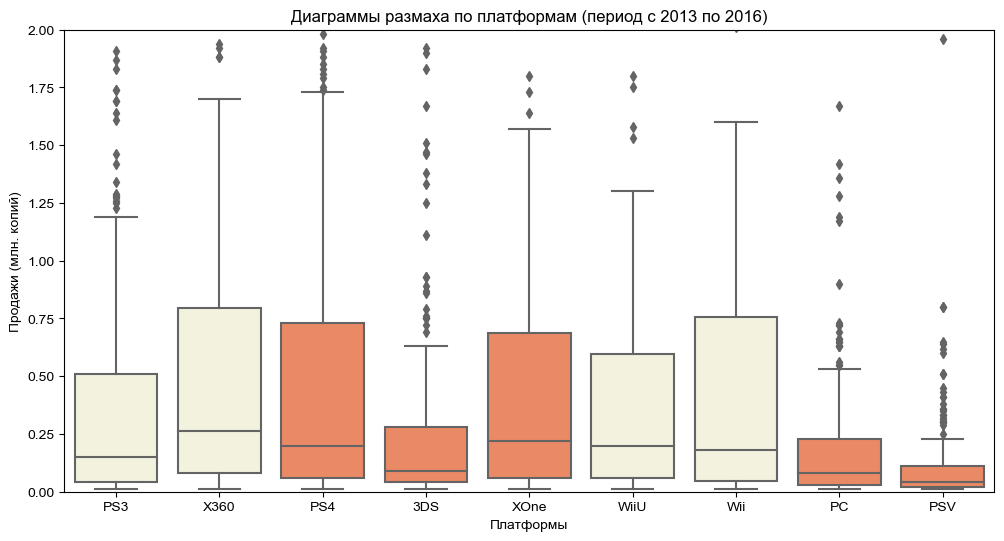

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

#сделаю палитру для потенциально перспектиывных платформ
my_colors = {x: 'coral' if x in ['PS4', 'XOne', 'PC', '3DS', 'PSV'] else 'beige' for x in platforms_rel.columns}
sns.boxplot(data=data_rel,
            x='platform', y='total_sales',
            palette=my_colors)
sns.set_style('whitegrid')

plt.ylim(0,2)
plt.title('Диаграммы размаха по платформам (период с 2013 по 2016)')
plt.xlabel('Платформы')
plt.ylabel('Продажи (млн. копий)');

На этом графике важно рассмотреть межквартильные размахи и медианные значения.  
Видно, что у PS4 размах продаж больше, чем у Xbox One и эта платформа лидировала про продажам с 2014 года. Тем не менее медианные продажи по играм у Xbox One немного выше, чем у PS4.  
Также продажи по 3DS и PC приблизительно одинаковы. В то время как продажи у PS Vita меньше раза в 3.

### Влияние отзывов на продажи

Чтобы изучить, как влияют отзывы на продажи, возьму отдельную платформу, по которой в актуальном периоде больше всего данных.

In [37]:
data_rel.groupby('platform')['user_score'].count().sort_values().tail()

platform
X360    143
PC      155
XOne    182
PS3     186
PS4     257
Name: user_score, dtype: int64

#### Влияние отзывов на продажи для PlayStation 4

Возьму платформу PlayStation 4, построю для нее диаграмму рассеяния по отзывам критиков и пользователей, а также посмотрю корреляцию отзывов между друг другом и их влияние на продажи. 

                Коэффициенты корреляции между
      оценками критиков и пользователей: 0.558
          оценками критиков и продажами: 0.407
     оценками пользователей и продажами: -0.032


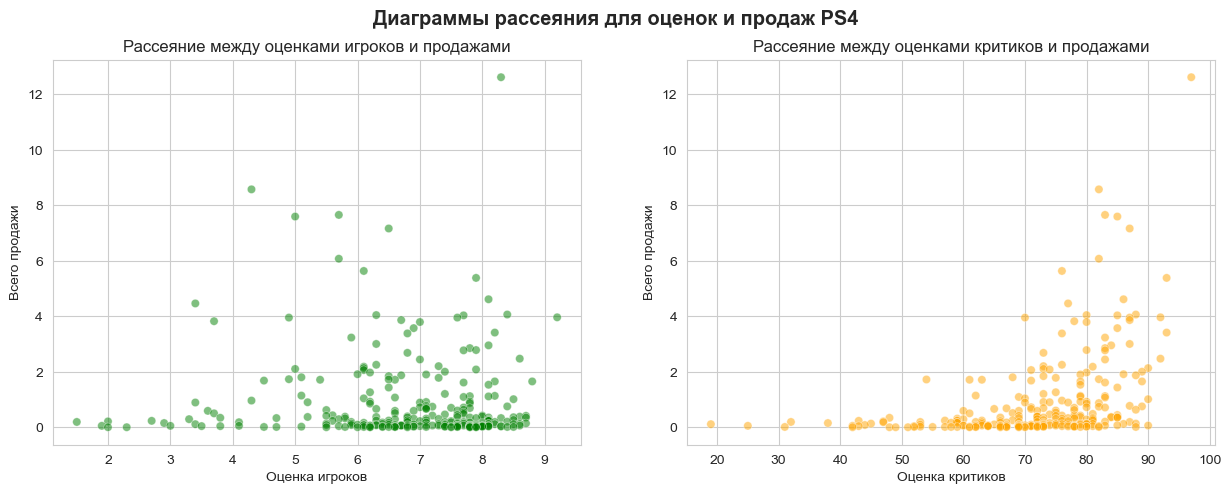

In [38]:
PS4_data = data_rel.query('platform == "PS4"')

#Посчитаю корреляцию
print('%45s'%'Коэффициенты корреляции между')
print('%40s'%'оценками критиков и пользователей:',
      round(PS4_data['critic_score'].corr(PS4_data['user_score']), 3) )
print('%40s'%'оценками критиков и продажами:',
     round(PS4_data['critic_score'].corr(PS4_data['total_sales']) , 3) )
print('%40s'%'оценками пользователей и продажами:',
     round(PS4_data['user_score'].corr(PS4_data['total_sales']), 3) )

#задам поле с двумя колонками для графиков
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize=(15, 5))
fig.suptitle('Диаграммы рассеяния для оценок и продаж PS4', size='x-large', fontweight='semibold')

#создам первый график
sns.scatterplot(data=PS4_data, x='user_score', y='total_sales', hue='platform',
                alpha=0.5, palette=['green'], legend=False, ax=axs[0])
axs[0].set_title('Рассеяние между оценками игроков и продажами')
axs[0].set_xlabel('Оценка игроков')
axs[0].set_ylabel('Всего продажи')

#создам второй график
sns.scatterplot(data=PS4_data, x='critic_score', y='total_sales', hue='platform',
               alpha=0.5, palette=['orange'], legend=False, ax=axs[1])
axs[1].set_title('Рассеяние между оценками критиков и продажами')
axs[1].set_xlabel('Оценка критиков')
axs[1].set_ylabel('Всего продажи');

Корреляции между оценками пользователей и продажами нет, а вот корреляция между оценками критиков и продажами - уже более ощутима (0.4), однако стоит понимать, что критики в целом дают оценки реже, и чаще для популярных игр, высокие продажи которых уже заведомо определены.  
А судя по корреляции оценок критиков и оценок пользователей - чаще они сходятся во мнении об игре.

#### Влияние отзывов на продажи для всех платформ

Для начала из интереса посмотрю распределения оценок пользователей и критиков.

Медиана для оценок игроков: 7.5
Медиана для оценок критиков: 71.0


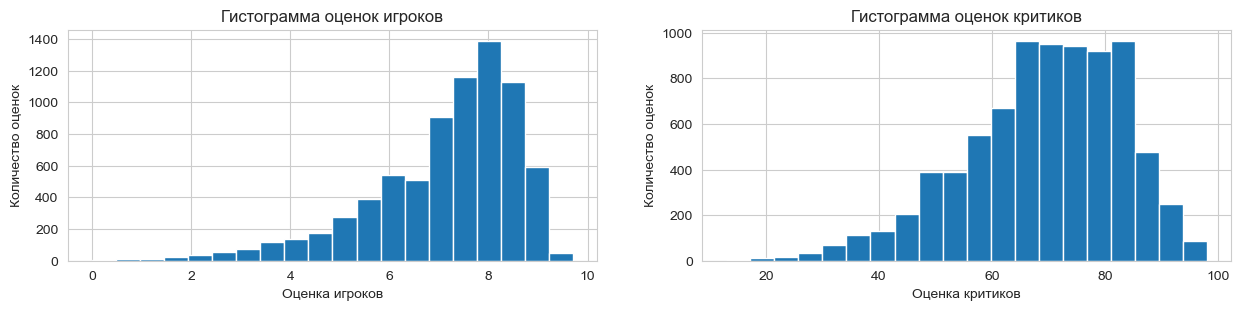

In [39]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize=(15, 3))

print('Медиана для оценок игроков:', data['user_score'].median())
print('Медиана для оценок критиков:', data['critic_score'].median())

data['user_score'].hist(bins=20, ax=axs[0])
axs[0].set_title('Гистограмма оценок игроков')
axs[0].set_xlabel('Оценка игроков')
axs[0].set_ylabel('Количество оценок')

data['critic_score'].hist(bins=20, ax=axs[1])
axs[1].set_title('Гистограмма оценок критиков')
axs[1].set_xlabel('Оценка критиков')
axs[1].set_ylabel('Количество оценок');

Посмотрю корреляцию оценок по всем платформам.

In [40]:
platforms_corr = pd.DataFrame(data=(
                                data_rel.loc[:, ['platform', 'critic_score', 'user_score', 'total_sales']]
                               .groupby('platform')
                               .corr()['total_sales']
                                    ))
platforms_corr.drop('total_sales', level=1, axis=0, inplace=True)
platforms_corr.style.background_gradient('coolwarm').format('{:.2f}')

По представленны данным заметны основные тенденции:  
1. Для всех платформ на продажи больше влияет оценка критиков
    - Для XOne и PS4 корреляция около 0.4
    - Для 3DS, WiiU, X360 около 0.36
    - Для остальных платформ корреляция менее ощутима
2. Оценка игроков не влияет на продажи
    - за единственным исключением для WiiU и Wii, у которого корреляция с оценкой игроков даже больше, чем с оценками критиков, и равна 0.4 и 0.68 соответственно

In [41]:
print('Корреляция продаж для всех платформ по оценкам критиков и игроков')
platforms_corr.groupby(level=1)['total_sales'].median()

Корреляция продаж для всех платформ по оценкам критиков и игроков


critic_score    0.353701
user_score      0.000942
Name: total_sales, dtype: float64

По медианным данным видна та же тенденция - небольшое влияние на продажи оказывают оценки критиков и никакого влияния не оказывают оценки игроков.

C:\Users\HOME\AppData\Local\Temp\ipykernel_18528\3695171602.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=data_rel, x='user_score', y='total_sales',


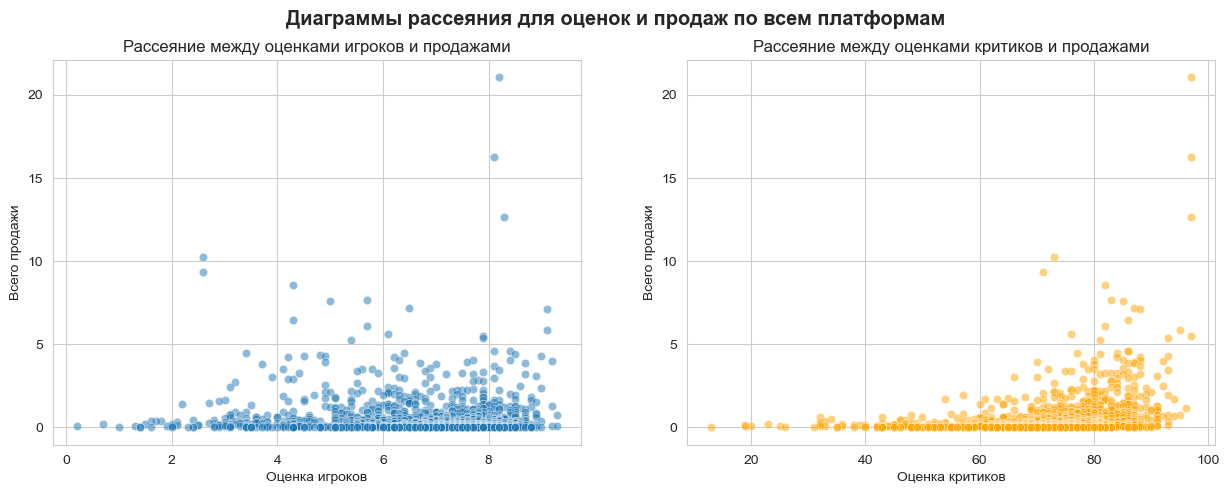

In [42]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize=(15, 5))
fig.suptitle('Диаграммы рассеяния для оценок и продаж по всем платформам', size='x-large', fontweight='semibold')

sns.scatterplot(data=data_rel, x='user_score', y='total_sales',
                alpha=0.5, palette=['green'], legend=False, ax=axs[0])
axs[0].set_title('Рассеяние между оценками игроков и продажами')
axs[0].set_xlabel('Оценка игроков')
axs[0].set_ylabel('Всего продажи')

sns.scatterplot(data=data_rel, x='critic_score', y='total_sales',
               alpha=0.5, color=['orange'], legend=False, ax=axs[1])
axs[1].set_title('Рассеяние между оценками критиков и продажами')
axs[1].set_xlabel('Оценка критиков')
axs[1].set_ylabel('Всего продажи');

По графикам рассеяния также видно, что у оценок критиков и продаж - более выраженная линейная корреляции.  
В диаграмме для оценок игроков и продаж распределение более хаотичное

### Распределение по жанрам

Оценю популярность жанров, посмотрев количество игр по каждому из них.

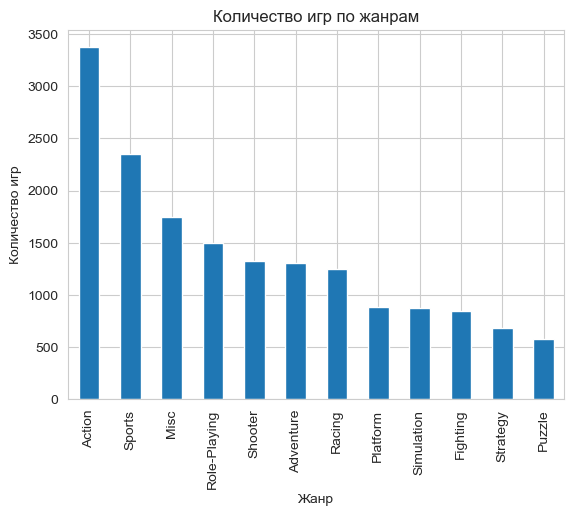

In [43]:
data.groupby('genre')['name'].count().sort_values(ascending=False)\
.plot(kind='bar', title='Количество игр по жанрам')
plt.xlabel('Жанр'), plt.ylabel('Количество игр');

Жанр _Action_, как самый динамичный жанр, является абсолютным лидером.  
Жанры _Misc(смешанные), Sports, Role-Play_ и _Adventure_ примерно одинаково популярны, но игр по ним почти в 3 раза меньше,  
чем игр в жанре _Action_. 

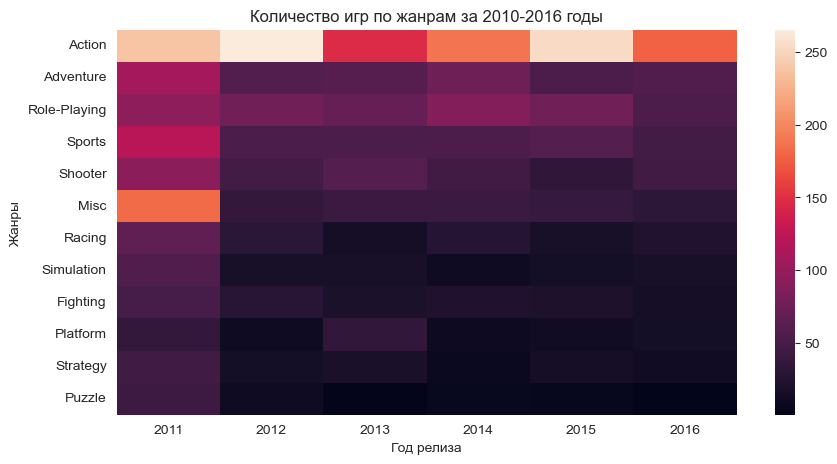

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[data['year_of_release'] > 2010]
            .pivot_table(index='genre', columns='year_of_release', values='name', aggfunc='count')\
.sort_values(by=2016, ascending=False))
plt.title('Количество игр по жанрам за 2010-2016 годы')
plt.xlabel('Год релиза'), plt.ylabel('Жанры');

На тепловой карте видно, что с течением времени, выпускается больше игр жанра _Action_.
<br>В 2016 году, например, игр в этом жанре было выпущено 178 игр.  
Для каждого жанра из _Adventure, Role-Play, Sports, Shooter_ было выпущено около 55 игр, что существенно меньше.

In [53]:
print('\033[1m' + '%35s'%'Динамика продаж по жанрам')
pd.DataFrame(data_rel.pivot_table(index='genre', columns='year_of_release', values='total_sales', aggfunc='sum')\
.sort_values(by=2016, ascending=False)).style.background_gradient('GnBu').format('{:.3f}')

          Динамика продаж по жанрам


year_of_release,2013,2014,2015,2016
genre,,,,
Shooter,62.040,65.210,67.510,38.220
Action,121.350,97.150,71.900,30.110
Sports,40.540,45.060,40.840,23.490
Role-Playing,43.420,45.620,37.640,18.180
Fighting,7.070,15.850,7.900,4.470
Adventure,5.400,5.520,8.160,3.820
Platform,23.850,8.810,6.050,3.230
Racing,12.370,16.660,8.070,2.790
Misc,25.040,23.360,11.570,2.600


Однако несмотря на количество игр, продажи рассказывают больше.  
Жанр шутеров долгое время конкурировал с экшнами по продажам, и в 2016 году стал самым продаваемым жанром, хотя все предыдущие годы жанром №1 был экшн.  
Причины могут быть разными - возможно, в 2016 году не выходило никаких крупных экшнов, а также, поскольку анализируются данные продавца - возможно, производители экшнов стали реализовывать свои продукты через другие каналы продаж.  
И все-таки можно выделить группу жанров с высокими продажами, это:  
1. Шутеры
2. Экшн
3. Спорт
4. Роул-плей

Продажи других категорий жанров существенно ниже.

Также посмотрю на ящики с усами для **продаж жанров**

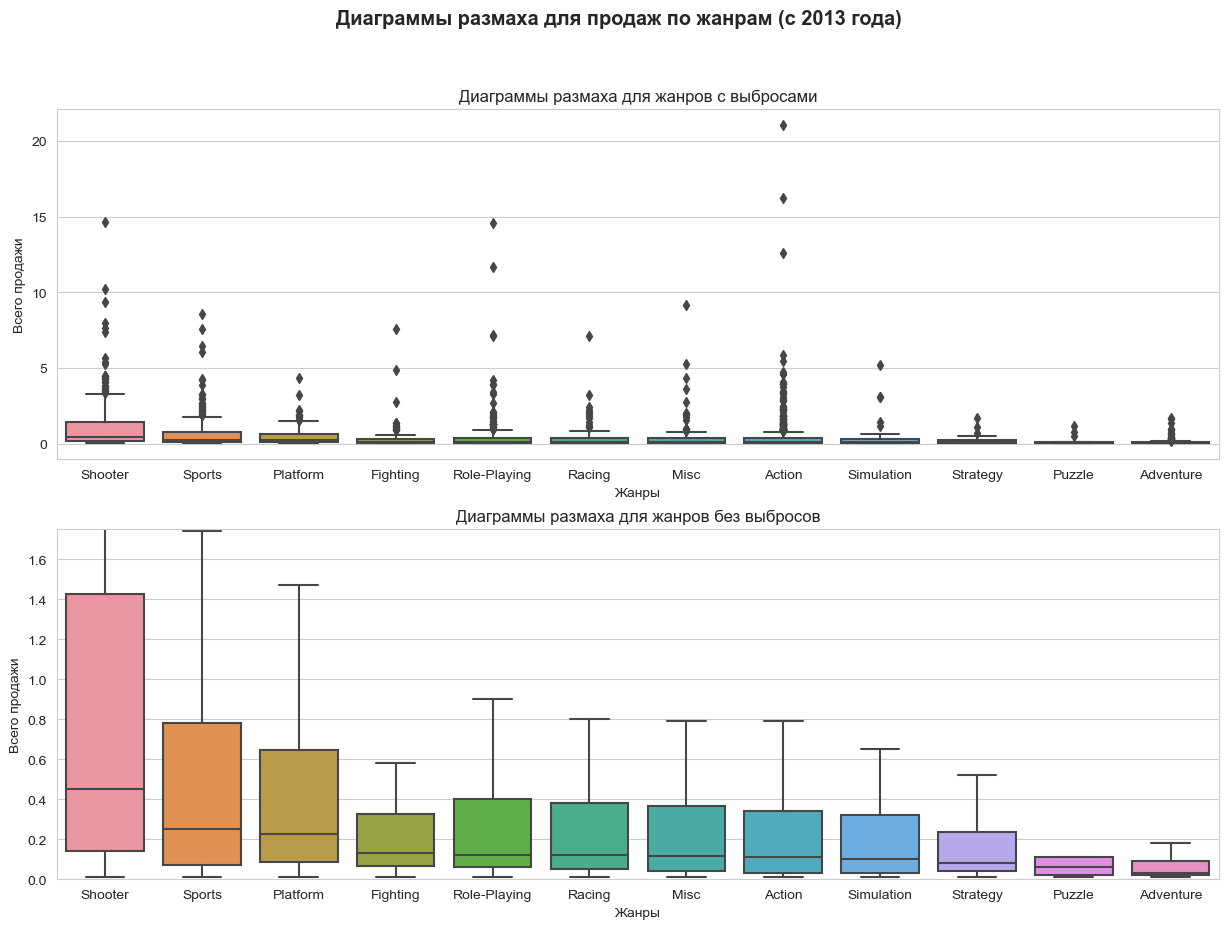

In [54]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1, figsize=(15, 10))
fig.suptitle('Диаграммы размаха для продаж по жанрам (с 2013 года)', size='x-large', fontweight='semibold')

#отсортирую графики по медианным значениям
median_order = data_rel.groupby('genre')['total_sales'].median().sort_values(ascending=False)

sns.boxplot(data=data_rel, x='genre', y='total_sales',
            ax=axs[0], order=median_order.index)
axs[0].set_title('Диаграммы размаха для жанров с выбросами')
axs[0].set_xlabel('Жанры')
axs[0].set_ylabel('Всего продажи')

sns.boxplot(data=data_rel, x='genre', y='total_sales', showfliers=False,
            ax=axs[1], order=median_order.index)
axs[1].set_title('Диаграммы размаха для жанров без выбросов')
axs[1].set_xlabel('Жанры')
axs[1].set_ylabel('Всего продажи')
plt.ylim(0,1.75);

В актуальном периоде по медианному значению суммы продаж топ жанров выглядит следующим образом:  
1. Шутеры
2. Спортивные игры
3. Платформеры  

У этих трех жанров также самые большие межквартильные размахи, то есть широкий разброс суммы продажи.  
Интересно, что популярный жанр Экшн - по медианному значению продаж является 8-м из 12-и. Несмотря на то, что игр в этом жанре продается больше всего - обычно продается не более 800 тыс. копий. Хотя в этом жанре и есть выбросы с продажами более 15 млн копий.  
Шутеры - очень хорошо продаваемый жанр. Их продажи обычно могут и достигать 3.35 млн копий (межквартильный размах). В купе с самой высокой медианой и наличием крупных выбросов с продажами до 15 млн копий это делает Шутеры очень перспективным жанром.

## Анализ регионов

Для каждого региона проанализирую продажи и определю наиболее популярные платформы и жанры.

### Распределение платформ по регионам

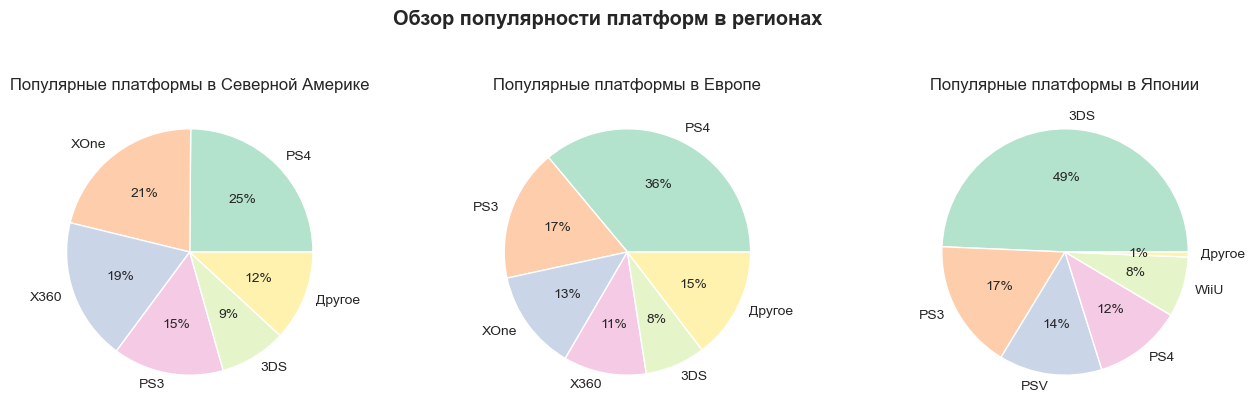

In [56]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize=(16, 4))
fig.suptitle('Обзор популярности платформ в регионах', size='x-large', fontweight='semibold', y=1.1)

for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    if region == 'na_sales':
        title = 'Северной Америке'
    elif region == 'eu_sales':
        title = 'Европе'
    else:
        title = 'Японии'
    #построю сводную таблицу и отсортирую ее по убыванию
    pie_data = (data_rel.pivot_table(index='platform', values=region, aggfunc='sum')
               .sort_values(by=region, ascending=False))
    #в other запишу сумму продаж по топ-6 и более платформам, назову их Другое
    other = pd.DataFrame({region:float(pie_data.iloc[5:].sum())}, index=['Другое'])
    #к топ-5 добавлю Другое
    pie_final = pd.concat([pie_data.head(5), other])
    
    #Построю график с подписями данных
    pie_final\
    .plot(kind='pie', ax=axs[i], subplots=True, legend=False, autopct='%1.0f%%',
         colors=sns.color_palette('Pastel2'))
    axs[i].set_title('Популярные платформы в ' + title)
    axs[i].set_ylabel(None)

Регионы отличаются в выборе платформ.  
Хотя в Северной Америке и Европе основные платформы - одни и те же, но их распределение разное.  
Так, в Европе приставки PS популярнее, чем Xbox, которые в америке почти одинаково распространены.
В Японии популярны мобильные (компактные) платформы - 3DS, PSV, которые не сыскали особого успеха в Америке и Европе.

### Распределение жанров по регионам

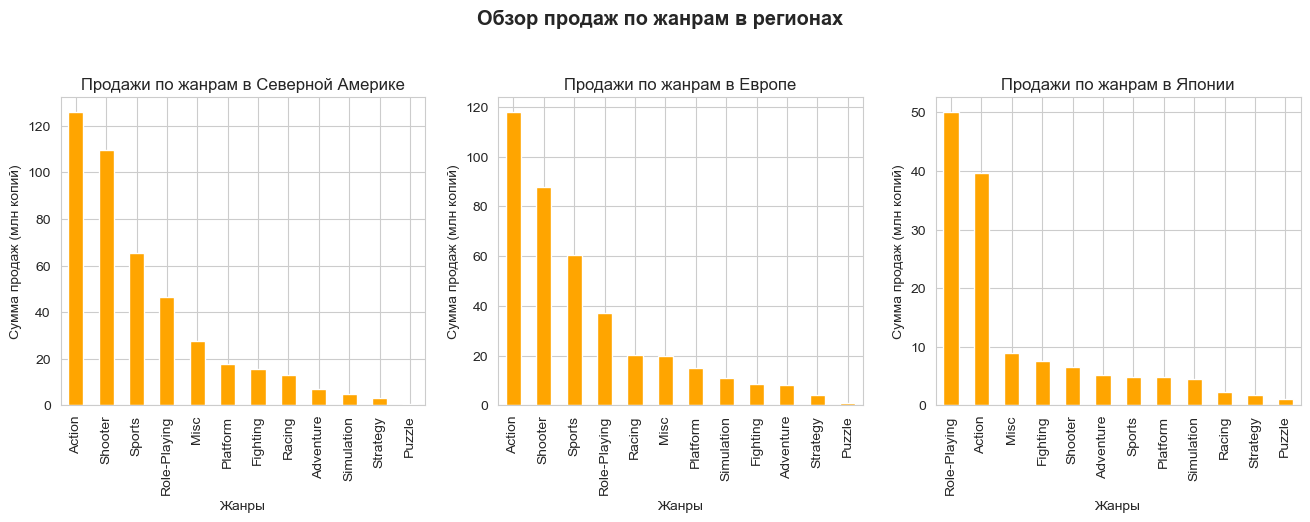

In [57]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize=(16, 4))
fig.suptitle('Обзор продаж по жанрам в регионах', size='x-large', fontweight='semibold', y=1.1)

for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    if region == 'na_sales':
        title = 'Северной Америке'
    elif region == 'eu_sales':
        title = 'Европе'
    else:
        title = 'Японии'
    data_rel.pivot_table(index='genre', values=region, aggfunc='sum')\
    .sort_values(by=region, ascending=False)\
    .plot(kind='bar', ax=axs[i], legend=False, color='orange')
    axs[i].set_title('Продажи по жанрам в ' + title)
    axs[i].set_xlabel('Жанры'), axs[i].set_ylabel('Сумма продаж (млн копий)')

Жанры в Северной Америке и Европе очень похожи.  
Топ-3 жанра для этих регионов - это _Экшн, Шутер_ и _Спорт_. Далее чередование жанров незначительно отличается.  
В Японии же другая картина. Там самые популярные жанры - это _Роул-Плей, Экшн, Миск(смешанные)_ и _Файтинги_.
<br>Такое отличие Японии от других регионов связано и с предпочтением платформы - компактные платформы лучше работают с мало-требовательными жанрами игр, такими как _Роул-Плей_ другими.

### Влияние рейтинга ESRB

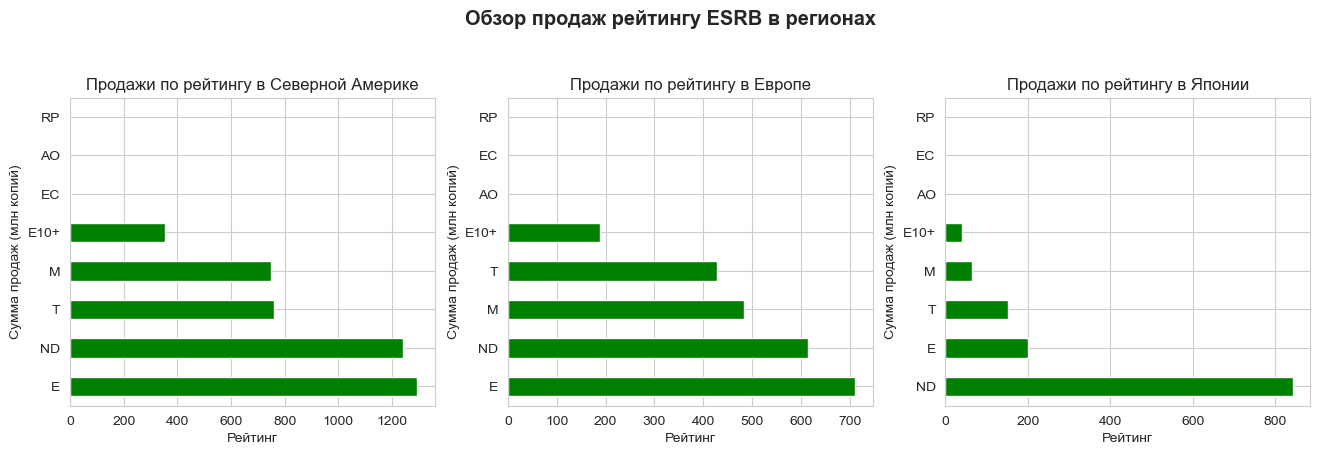

In [58]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize=(16, 4))
fig.suptitle('Обзор продаж рейтингу ESRB в регионах', size='x-large', fontweight='semibold', y=1.1)

for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    if region == 'na_sales':
        title = 'Северной Америке'
    elif region == 'eu_sales':
        title = 'Европе'
    else:
        title = 'Японии'
    data.pivot_table(index='rating', values=region, aggfunc='sum')\
    .sort_values(by=region, ascending=False)\
    .plot(kind='barh', ax=axs[i], legend=False, color='green')
    axs[i].set_title('Продажи по рейтингу в ' + title)
    axs[i].set_xlabel('Рейтинг'), axs[i].set_ylabel('Сумма продаж (млн копий)')

В Северной Америке и Европе, как и с жанрами, ситуация похожая.  
Самые популярные рейтинги:  
- Everyone (без возрастных ограничений)
- Игры без рейтинга, определенного ESRB  
- Mature (от 17 лет)
- Teen (от 13 лет)  

В Японии же больше всего играют в игры, в которых рейтинг не определен. Видимо, в Японии популярны совсем другие игры, по сравнению с Европой и Северной Америкой. Все-таки ESRB больше ориентируется на европейский и американский мир и не присваивает рейтинг азиатским играм.

### Портрет потребителя по региону

Потребитель из **Северной Америки**:  
1. Играет в PS4, Xbox One и эти же платформы ранней версии  
2. Предпочитает игры жанра Action, Shooter или Sports  
3. С рейтингом без возрастных ограничений, с неопределенным рейтингом, в 1.5 раза реже в игры от 13 и 17 лет  

Потребитель из **Европы**:  
1. Играет в PS4, Xbox One и эти же платформы ранней версии  
2. Предпочитает игры жанра Action, Shooter или Sports  
3. С рейтингом без возрастных ограничений, с неопределенным рейтингом, в 1.5 раза реже в игры от 13 и 17 лет  

Потребитель из **Японии**:  
1. Играет в портативные приставки 3DS, PSV, реже в домашнюю консоль PlayStation  
2. Предпочитает жанры Role-Playing, Action, Misc, Fighting  
3. С неопределенным рейтингом и в 4 раза реже с рейтингом без ограничений

## Проверка гипотез

### Гипотеза о различиях в пользовательских рейтингах для платформ Xbox One и PC.

Я предполагаю, что пользовательские рейтинги для платформ Xbox One и PC могут отличаться.  
Так как игра на этих платформах - это разный опыт, игры на них подразумевают разные способы управления, по-разному оптимизируются и иногда по-разному выглядят. Поэтому возможно, что рейтинги игроков для этих платформ будут отличаться.  
Гипотезы будут выглядеть следующим образом:

_Нулевая гипотеза:_ Пользовательские рейтинги Xbox One и PC в среднем равны.  
_Альтернативная гипотеза:_ Пользовательские рейтинги Xbox One **отличаются** от пользовательских рейтингов PC.

За уровень достоверности возьму альфа, равное 5%.  
Так как тест не проведется, пока в данных есть пропуски - удалю их из столбца с пользовательским рейтингом. И скорректирую выборку так, чтобы учитывались только данные с 2013 года, чтобы уравнять условия для новой приставки и долговечного ПК.

In [59]:
hyp1_data = data_rel[data_rel['user_score'].notna()].query('year_of_release >= 2013')

#Поскольку тут проверяется гипотеза для двух выборок воспользуюсь методом ttes_ind
hyp1 = st.ttest_ind(hyp1_data.query('platform == "XOne"')['user_score'],
                    hyp1_data.query('platform == "PC"')['user_score'],
                    alternative='two-sided')

print('P-value гипотезы:', hyp1.pvalue)

if hyp1.pvalue < 0.05:
    print('Нулевая гипотеза отвергается в пользу альтернативной')
else:
    print('Нулевая гипотеза не может быть отвергнута')

P-value гипотезы: 0.14012658403611647
Нулевая гипотеза не может быть отвергнута


P-value достаточно большое. С вероятностью в 14% различия между выборками можно получить случайно.  
Значит, что при выбранном пороге альфа в 5% нулевая гипотеза не может быть отвергнута, и пользовательские рейтинги для Xbox One и PC в среднем равны.

### Гипотеза о разности пользовательского рейтинга для жанров Action и Sports

_Нулевая гипотеза:_ Пользовательский рейтинг для Action и Sports игр равен.  
_Альтернативная гипотеза_ Пользовательский рейтинг для Action-игр не одинаков.

In [70]:
hyp2_data = data_rel[data_rel['user_score'].notna()].query('genre == "Sports" or genre == "Action"')

#Поскольку и здесь проверяется гипотеза для двух выборок,
#снова воспользуюсь методом ttes_ind
hyp2 = st.ttest_ind(hyp2_data.query('genre == "Action"')['user_score'],
                    hyp2_data.query('genre == "Sports"')['user_score'],
                    alternative='two-sided', equal_var=False)

print('P-value гипотезы:', hyp2.pvalue)

if hyp2.pvalue < 0.05:
    print('Нулевая гипотеза отвергается в пользу альтернативной')
else:
    print('Нулевая гипотеза не может быть отвергнута')

P-value гипотезы: 2.419141451747253e-20
Нулевая гипотеза отвергается в пользу альтернативной


Статистический тест показал, что рейтинги жанров *Экшн* и *Спорт* статистически не одинаковы, их отличия обусловлены не случайностью.

# Вывод

Анализ проходил в несколько этапов. Для удобства представлю результаты, разделив их на основные пункты.

**1. Развитие рынка компьютерных игр и платформ**  
Рост рынка заметен с 2002 года. К 2008 году было магазин продавал около 1429 игр.  
В 2016 году в магазине продавалось 502 игры. Количество игр сократилось, возможно потому, что компании стали тщательнее прорабатывать игры и количество релизов уменьшилось, а возможно - потому, что производители стали выбирать другие каналы продаж и осуществлять ее не через магазин.

Медианная продолжительность жизни новой игровой платформы равна **8 годам**.  
<br>Для дальнейшего анализа был выбран период с 2013 года.

**2. Игровые платформы в актуальном периоде**  
Наиболее актуальные платформы - PS4, Xbox One, за последние 4 года продажи по этим платформам росли больше других и стоит ожидать, что они несущественно сократятся в 2017.  
Также стоит обратить внимание на PC, так как эта платформа актуальна дольше всех и в 2016 году заняла четвертое место в топе по самым продаваемым играм для платформ.

**3. Корреляция между оценками и продажами**  
Корреляция между оценками _критиков_ и продажами равна 0,4.  
Корреляции между оценками _пользователей_ и продажами не выявлена.

Больше всего корреляция между оценками критиков и продажами выражена у платформ PS4 и Xbox One, коэффициент равен 0.4  
Ниже он для 3DS и WiiU (0.36).

**4. Исследование жанров**  
Лидер в количестве игр по жанрам - экшн-игры. В пять раз меньше игр представлено в приключенческих жанрах, роул-плее, спортивных играх и шутерах.  
Лидеры продаж в 2016 году:
1. Шутеры (29,4%)
2. Экшн (23,17%)
3. Спортивные (18%)

Но стоит учитывать, что обычно лидируют игры в жанре экшн.

**5. Портрет потребителей по регионам**  
Потребитель из *Северной Америки*:  
1. Играет в PS4, Xbox One и эти же платформы ранней версии  
2. Предпочитает игры жанра Action, Shooter или Sports  
3. С рейтингом без возрастных ограничений, с неопределенным рейтингом, в 1.5 раза реже в игры от 13 и 17 лет  

Потребитель из *Европы*:  
1. Играет в PS4, Xbox One и эти же платформы ранней версии  
2. Предпочитает игры жанра Action, Shooter или Sports  
3. С рейтингом без возрастных ограничений, с неопределенным рейтингом, в 1.5 раза реже в игры от 13 и 17 лет  

Потребитель из *Японии*:  
1. Играет в портативные приставки 3DS, PSV, реже в домашнюю консоль PlayStation  
2. Предпочитает жанры Role-Playing, Action, Misc, Fighting  
3. С неопределенным рейтингом и в 4 раза реже с рейтингом без ограничений

**6. Проверка гипотез**  
Пользовательские рейтинги для Xbox One и PC в среднем равны.  
Пользовательские рейтинги для игр в жанре Action отличаются от игр в жанре Sports.

**Рекомендации для магазина:**  
1. Провести анализ снижения продаж, выявить причины и сформировать стратегию по минимизации негативного эффекта  


2. В 2017 году концентрироваться на актуальных платформах:  
    - PS4, Xbox One - платформы, которые хорошо росли за последние 4 года. Стоит ожидать, что продажи по ним будут актуальны еще около 3-4 лет. PS4 в среднем росла в 1,87 раз и Xbox One в 1,47 раз.
    - Nintendo 3DS и PS Vita - платформы, которыми больше пользуются в Японии. Эти платформы приносят не так много продаж, но они достаточно стабильны. Можно рассматривать эти платформы на краткосрочный период (до 2 лет).
    - На долгосрочный период важно обращать внимание на игры для грядущих новых поколений приставок PS и Xbox.
    - Также не стоит забывать о самой долгосрочно-актуальной платформе PC, хотя продажи по ней и меньше, чем у игр для приставок.
    
    
3. Предлагать потребителю игры с высокими оценками критиков.  
Корреляция между оценкой критиков и продажами = 0.4


4. В маркетинге и сбыте учитывать особенности потребителей
    - Для потребителей из Северной Америки актуальны игры на Xbox и PS в жанрах Action, Shooter и Sports с рейтингом E
    - Для потребителей из Европы актуальны игры на PS, Xbox и PC в жанрах Action, Shooter и Sports с рейтингом E
    - Для потребителей из Японии актуальны игры на портативных консолях, реже на PS в жанрах Role-playing, Action, Misc, Platformer с неопределенным рейтингом